In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import sys, os
sys.path.append('../../src/')
# import toolbox
from toolbox import *

result_names = ['BBT_Tiingo',                #0
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',     #2
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',     #4
                'BBT_future_BITX',
                'BBT_future_BITW20',         #6
                'BBT_future_BITW70', 
                'BBT_future_BITW100',        #8
                'BBT_future_CRIX']

risk_measures = ['Variance',
                 'ES q=0.05', 'ES q=0.01',
                 'VaR q=0.05', 'VaR q=0.01', 
                 'ERM k=10', 'CH']

order = ['BBT_Tiingo',    
         'BBT_future_CRIX',  'BBT_future_BITX', 'BBT_future_BITW100', 
         'BBT_future_BITW20',  'BBT_future_BITW70',
         'BBT_future_Tiingo_ada', 'BBT_future_Tiingo_eth',  'BBT_future_Tiingo_ltc','BBT_future_Tiingo_xrp']

coin_names = ['btc', 'CRIX', 'BITX', 'BITW100', 'BITW20', 'BITW70', 'ada', 'eth', 'ltc', 'xrp']

In [67]:
from arch import arch_model
from arch.univariate import StudentsT
from copulae1 import *

In [49]:
rn = 'BBT_Tiingo'

path = '../../processed_data/%s/train/0.csv'%rn
df = pd.read_csv(path)

df.Date = pd.to_datetime(df.Date)
df = df.sort_values('Date')

rs = df.loc[:,'log return bitcoin']
rf = df.loc[:,'log return future']

am_rs = arch_model(list(rs), p=2, o=2, q=2, dist='studentst')
res_rs = am_rs.fit(update_freq=5, disp="off")

am_rf = arch_model(list(rf), p=2, o=2, q=2, dist='studentst')
res_rf = am_rf.fit(update_freq=5, disp="off")


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:312: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001796. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:312: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001992. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warnin

In [133]:
train_path = '../../processed_data/%s/train/'%rn
test_path = '../../processed_data/%s/train/'%rn

files = [f for f in os.listdir(train_path) if f.endswith('.csv')]

files = list(pd.DataFrame(files, index=[int(f.replace('.csv', '')) for f in files])\
.sort_index().loc[:,0])

In [230]:
import scipy.stats
# res_rs.params.nu


test_results = []

for f in files:
    print(f)
# fit GJR-GARCH
    path = '../../processed_data/%s/train/%s'%(rn, f)
    df = pd.read_csv(path)
    
    df.Date = pd.to_datetime(df.Date)
    df = df.sort_values('Date')

    rs = df.loc[:,'log return bitcoin']*100
    rf = df.loc[:,'log return future']*100

    am_rs = arch_model(list(rs), p=1, o=1, q=1, dist='studentst')
    res_rs = am_rs.fit(update_freq=0, disp="off")

    am_rf = arch_model(list(rf), p=1, o=1, q=1, dist='studentst')
    res_rf = am_rf.fit(update_freq=0, disp="off")

    u = []
    v = []

    CV_rs = res_rs.conditional_volatility
    nu_rs = res_rs.params.nu
    mu_rs = res_rs.params.mu

    CV_rf = res_rf.conditional_volatility
    nu_rf = res_rf.params.nu
    mu_rf = res_rf.params.mu

    for i in range(len(CV_rf)):
#         if i == len(CV_rf)-1:
#             break
        u.append(stats.t(df=nu_rs, scale=np.sqrt(CV_rs[i])).cdf(rs[i]-mu_rs))
        v.append(stats.t(df=nu_rf, scale=np.sqrt(CV_rf[i])).cdf(rf[i]-mu_rf))

    u_ecdf = ECDF(rs)(rs)
    v_ecdf = ECDF(rf)(rf)

#     C_GARCH = Gaussian({'rho':0.8}, stats.uniform, stats.uniform)
    C_GARCH = t_Copula({'rho':0.8, 'nu':4}, stats.uniform, stats.uniform, nu_lowerbound=2)
    C_GARCH.canonical_calibrate(u,v)

    C_ECDF = t_Copula({'rho':0.8, 'nu':4}, stats.uniform, stats.uniform, nu_lowerbound=2)
    C_ECDF.canonical_calibrate(u_ecdf,v_ecdf)


    # samples
    samples_GARCH = C_GARCH.sample(1000)
    samples_ECDF  = C_ECDF.sample(1000)

    samples_GARCH[:,0] = stats.t(df=nu_rs, scale=np.sqrt(CV_rs[-1])).ppf(samples_GARCH[:,0])\
                            +mu_rs
    samples_GARCH[:,1] = stats.t(df=nu_rf, scale=np.sqrt(CV_rf[-1])).ppf(samples_GARCH[:,1])\
                            +mu_rf

    samples_ECDF[:,0] = np.quantile(rs, samples_ECDF[:,0])
    samples_ECDF[:,1] = np.quantile(rf, samples_ECDF[:,1])

    h_arr = np.linspace(0.5,1.5,1000)

    var_GARCH = []
    var_ECDF = []

    for h in h_arr:
        var_GARCH.append(np.var(samples_GARCH[:,0] - h*samples_GARCH[:,1]))
        var_ECDF.append(np.var(samples_ECDF[:,0] - h*samples_ECDF[:,1]))

    h_GARCH = h_arr[np.argmin(var_GARCH)]
    h_ECDF = h_arr[np.argmin(var_ECDF)]

    print(h_GARCH, h_ECDF)
    
    test_path =  '../../processed_data/%s/test/%s'%(rn, f)
    test      =  pd.read_csv(test_path)
    
    rs_test = test.loc[:, 'log return bitcoin']
    rf_test = test.loc[:, 'log return future']

    test.loc[:, 'h_GARCH'] = h_GARCH
    test.loc[:, 'h_ECDF'] = h_ECDF

    test.loc[:,'rh_GARCH'] = rs_test-h_GARCH*rf_test
    test.loc[:,'rh_ECDF'] = rs_test-h_ECDF*rf_test
    test_results.append(test)
print("DONE")

0.csv
Optimization terminated successfully.
         Current function value: -779.541393
         Iterations: 93
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: -775.179209
         Iterations: 97
         Function evaluations: 213
1.0155155155155156 0.9414414414414414
1.csv
Optimization terminated successfully.
         Current function value: -792.884930
         Iterations: 95
         Function evaluations: 206
Optimization terminated successfully.
         Current function value: -772.762123
         Iterations: 91
         Function evaluations: 199
0.9954954954954955 0.9494494494494494
2.csv
Optimization terminated successfully.
         Current function value: -779.505530
         Iterations: 94
         Function evaluations: 205
Optimization terminated successfully.
         Current function value: -765.219085
         Iterations: 86
         Function evaluations: 188
0.9964964964964965 0.9534534534534534
3.csv
Optimizati

Optimization terminated successfully.
         Current function value: -739.079267
         Iterations: 104
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: -742.065618
         Iterations: 138
         Function evaluations: 257
0.9654654654654655 0.9354354354354355
26.csv
Optimization terminated successfully.
         Current function value: -739.914545
         Iterations: 97
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: -738.666002
         Iterations: 179
         Function evaluations: 336
0.9764764764764764 0.9384384384384384
27.csv
Optimization terminated successfully.
         Current function value: -729.685549
         Iterations: 95
         Function evaluations: 207
Optimization terminated successfully.
         Current function value: -740.732530
         Iterations: 154
         Function evaluations: 284
1.0115115115115114 0.9424424424424425
28.csv
Optimizat

Optimization terminated successfully.
         Current function value: -736.006810
         Iterations: 144
         Function evaluations: 276
1.0455455455455456 0.9624624624624625
51.csv
Optimization terminated successfully.
         Current function value: -728.940414
         Iterations: 159
         Function evaluations: 299
Optimization terminated successfully.
         Current function value: -732.299295
         Iterations: 159
         Function evaluations: 301
0.9814814814814814 0.9644644644644644
52.csv
Optimization terminated successfully.
         Current function value: -729.390399
         Iterations: 123
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -725.854679
         Iterations: 167
         Function evaluations: 304
0.9194194194194194 0.9704704704704705
53.csv
Optimization terminated successfully.
         Current function value: -705.669264
         Iterations: 109
         Function evaluations: 212
Optimiz

Optimization terminated successfully.
         Current function value: -562.033433
         Iterations: 156
         Function evaluations: 297
1.0265265265265264 0.9724724724724725
76.csv
Optimization terminated successfully.
         Current function value: -527.672232
         Iterations: 83
         Function evaluations: 179
Optimization terminated successfully.
         Current function value: -561.843446
         Iterations: 149
         Function evaluations: 282
1.0295295295295295 0.9684684684684685
77.csv
Optimization terminated successfully.
         Current function value: -527.972331
         Iterations: 80
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: -562.270785
         Iterations: 130
         Function evaluations: 251
1.0635635635635636 0.9714714714714714
78.csv
Optimization terminated successfully.
         Current function value: -529.556314
         Iterations: 74
         Function evaluations: 165
Optimizati

LinAlgError: singular matrix

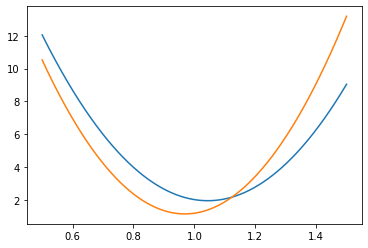

In [231]:
h_arr = np.linspace(0.5,1.5,1000)

var_GARCH = []
var_ECDF = []

for h in h_arr:
    var_GARCH.append(np.var(samples_GARCH[:,0] - h*samples_GARCH[:,1]))
    var_ECDF.append(np.var(samples_ECDF[:,0] - h*samples_ECDF[:,1]))

h_GARCH = h_arr[np.argmin(var_GARCH)]
h_ECDF = h_arr[np.argmin(var_ECDF)]


plt.plot(h_arr, var_GARCH)
plt.plot(h_arr, var_ECDF)


In [232]:
print(nu_rs, nu_rf)

2.567452758436798 2.680377426467978


In [233]:
print(mu_rs, mu_rf)

0.08732707334008115 0.11267624835440294


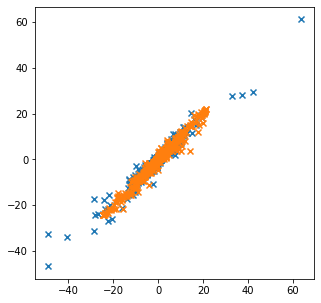

In [234]:
plt.figure(figsize=(5,5))
plt.scatter(samples_GARCH[:,0], samples_GARCH[:,1], marker='x')
plt.scatter(samples_ECDF[:,0], samples_ECDF[:,1], marker='x')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


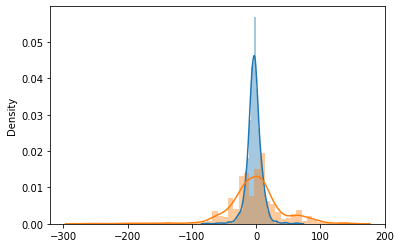

In [417]:
sns.distplot(samples_GARCH[:,1])
sns.distplot(samples_ECDF[:,1])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


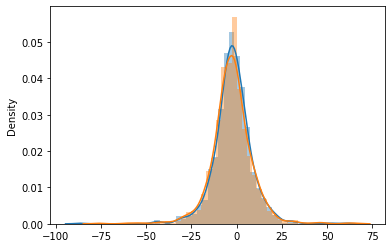

In [418]:
sns.distplot(samples_GARCH[:,0])
sns.distplot(samples_GARCH[:,1])

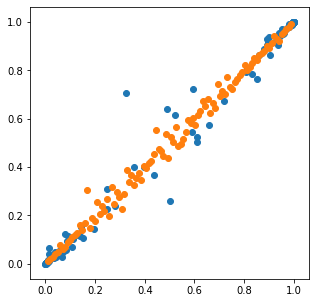

In [411]:
plt.figure(figsize=(5,5))
plt.scatter(u, v)
plt.scatter(u_ecdf, v_ecdf)

# plt.scatter(samples_ECDF[:,0], samples_ECDF[:,1])

In [237]:
results = pd.concat(test_results)
results.Date = pd.to_datetime(results.Date)
results = results.sort_values('Date')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


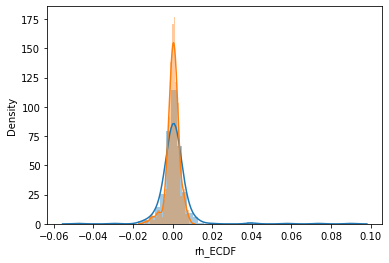

In [238]:
sns.distplot(results.rh_GARCH)
sns.distplot(results.rh_ECDF)

In [376]:
print(np.mean(results.rh_GARCH),
      np.mean(results.rh_ECDF))

0.0008681879857543307 0.00023436646365282917


In [377]:
print(np.std(results.rh_GARCH),
      np.std(results.rh_ECDF))

0.008860675992492368 0.003224941957931821


In [378]:
print(np.mean(results.rh_GARCH)/np.std(results.rh_GARCH),
      np.mean(results.rh_ECDF)/np.std(results.rh_ECDF))

0.09798213888984819 0.07267307961199095


In [379]:
print(-np.quantile(results.rh_GARCH, 0.05),
      -np.quantile(results.rh_ECDF, 0.05))

0.007861567697277942 0.005954220036701558


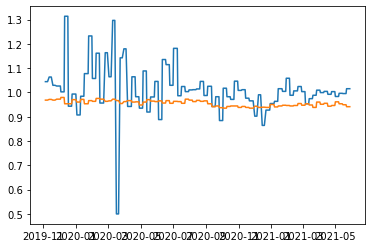

In [380]:
plt.plot(results.Date, results.h_GARCH)
plt.plot(results.Date, results.h_ECDF)

In [354]:
path = '../../data/cleaned_data/BBT_Tiingo.csv'
# path = '../../data/cleaned_data/BBT_future_Tiingo_eth.csv'
df = pd.read_csv(path)
df.Date = pd.to_datetime(df.Date)
df = df.sort_values('Date')
df.reset_index(drop=True, inplace=True)

train_size = int(np.floor(len(df)*2/3))
test_size = train_size
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(len(train))


578


In [463]:
h_GARCH_arr = []
h_ECDF_arr = []


block_size = 100

for i in range(block_size, len(train)):
    print(i)
    rs = np.array(train.iloc[i-block_size:i, :].loc[:, 'log return bitcoin']*1000)
    rf = np.array(train.iloc[i-block_size:i, :].loc[:, 'log return future']*1000)
    
    am_rs = arch_model(rs, p=5, o=5, q=5, dist='studentst')
    res_rs = am_rs.fit(update_freq=0, disp="off")

    am_rf = arch_model(rf, p=5, o=5, q=5, dist='studentst')
    res_rf = am_rf.fit(update_freq=0, disp="off")

    u = []
    v = []

    CV_rs = res_rs.conditional_volatility
    nu_rs = res_rs.params.nu
    mu_rs = res_rs.params.mu

    CV_rf = res_rf.conditional_volatility
    nu_rf = res_rf.params.nu
    mu_rf = res_rf.params.mu

    for i in range(len(CV_rf)):
        if i == len(CV_rf)-1:
            break
        u.append(stats.t(df=nu_rs, scale=np.sqrt(CV_rs[i])).cdf(rs[i+1]-mu_rs))
        v.append(stats.t(df=nu_rf, scale=np.sqrt(CV_rf[i])).cdf(rf[i+1]-mu_rf))

        
    u = np.array(u)
    u[u==1] = 0.9999999999999999

    v = np.array(v)
    v[v==1] = 0.9999999999999999
    u_ecdf = ECDF(rs)(rs)
    v_ecdf = ECDF(rf)(rf)

#     C_GARCH = rot180Gumbel({'theta':1.1}, stats.uniform, stats.uniform)
#     C_GARCH = Gaussian({'rho':0.8}, stats.uniform, stats.uniform)
   #, q_arr=[0.05,0.1,0.9,0.95])
    C_GARCH = t_Copula({'rho':0.1, 'nu':4}, stats.uniform, stats.uniform, nu_lowerbound=2)
    C_GARCH.canonical_calibrate(np.array(u), np.array(v))

#     C_ECDF = Gaussian({'rho':0.8}, stats.uniform, stats.uniform)
#     C_ECDF = rot180Gumbel({'theta':1.1}, stats.uniform, stats.uniform)
    C_ECDF = t_Copula({'rho':0.1, 'nu':4}, stats.uniform, stats.uniform, nu_lowerbound=2)
    C_ECDF.canonical_calibrate(np.array(u_ecdf), np.array(v_ecdf) )

    # samples
    samples_GARCH = C_GARCH.sample(1000)
    samples_ECDF  = C_ECDF.sample(1000)

    samples_GARCH[:,0] = stats.t(df=nu_rs, scale=np.sqrt(CV_rs[-1])).ppf(samples_GARCH[:,0])\
                            +mu_rs
    samples_GARCH[:,1] = stats.t(df=nu_rf, scale=np.sqrt(CV_rf[-1])).ppf(samples_GARCH[:,1])\
                            +mu_rf

    samples_ECDF[:,0] = np.quantile(rs, samples_ECDF[:,0])
    samples_ECDF[:,1] = np.quantile(rf, samples_ECDF[:,1])

    h_arr = np.linspace(0,2,1000)

    var_GARCH = []
    var_ECDF = []

    for h in h_arr:
        var_GARCH.append(np.var(samples_GARCH[:,0] - h*samples_GARCH[:,1]))
        var_ECDF.append(np.var(samples_ECDF[:,0] - h*samples_ECDF[:,1]))

    h_GARCH = h_arr[np.argmin(var_GARCH)]
    h_ECDF = h_arr[np.argmin(var_ECDF)]
    
    h_GARCH_arr.append(h_GARCH)
    h_ECDF_arr.append(h_ECDF)
    print('%.4f %.4f' %(h_GARCH, h_ECDF))
    
print('Done!')

100


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -1551.740585
         Iterations: 162
         Function evaluations: 314
Optimization terminated successfully.
         Current function value: -218.907936
         Iterations: 168
         Function evaluations: 317
0.9309 1.0010
101


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -1455.838374
         Iterations: 162
         Function evaluations: 307
Optimization terminated successfully.
         Current function value: -229.704246
         Iterations: 130
         Function evaluations: 272
0.8388 0.9910
102
Optimization terminated successfully.
         Current function value: -1836.036070
         Iterations: 92
         Function evaluations: 202
Optimization terminated successfully.
         Current function value: -230.424688
         Iterations: 135
         Function evaluations: 281
0.7568 0.9910
103
Optimization terminated successfully.
         Current function value: -1392.683203
         Iterations: 97
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: -230.938612
         Iterations: 133
         Function evaluations: 279
0.6847 0.9970
104


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -1097.660166
         Iterations: 167
         Function evaluations: 324
Optimization terminated successfully.
         Current function value: -230.663876
         Iterations: 130
         Function evaluations: 275
0.7688 1.0070
105


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -940.398349
         Iterations: 153
         Function evaluations: 307
Optimization terminated successfully.
         Current function value: -231.705959
         Iterations: 161
         Function evaluations: 312
0.7187 1.0070
106


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -842.227968
         Iterations: 177
         Function evaluations: 345
Optimization terminated successfully.
         Current function value: -232.642179
         Iterations: 148
         Function evaluations: 308
0.7107 0.9930
107


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -774.278490
         Iterations: 175
         Function evaluations: 334
Optimization terminated successfully.
         Current function value: -232.425940
         Iterations: 138
         Function evaluations: 288
0.6987 1.0030
108


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -890.971135
         Iterations: 177
         Function evaluations: 336
Optimization terminated successfully.
         Current function value: -231.931382
         Iterations: 153
         Function evaluations: 315
0.7227 0.9930
109


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -1205.955128
         Iterations: 183
         Function evaluations: 350
Optimization terminated successfully.
         Current function value: -233.200148
         Iterations: 138
         Function evaluations: 290
0.8168 0.9970
110
Optimization terminated successfully.
         Current function value: -1979.563071
         Iterations: 91
         Function evaluations: 200
Optimization terminated successfully.
         Current function value: -233.521730
         Iterations: 141
         Function evaluations: 298
0.7628 1.0050
111
Optimization terminated successfully.
         Current function value: -1998.339975
         Iterations: 96
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: -233.400033
         Iterations: 135
         Function evaluations: 282
0.8108 1.0110
112
Optimization terminated successfully.
         Current function value: -1947.519457
   

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -847.965482
         Iterations: 136
         Function evaluations: 260
Optimization terminated successfully.
         Current function value: -232.866327
         Iterations: 135
         Function evaluations: 292
0.6286 1.0150
115
Optimization terminated successfully.
         Current function value: -1872.071199
         Iterations: 115
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -233.923982
         Iterations: 133
         Function evaluations: 280
0.8308 1.0110
116
Optimization terminated successfully.
         Current function value: -1837.412891
         Iterations: 101
         Function evaluations: 215
Optimization terminated successfully.
         Current function value: -232.916996
         Iterations: 126
         Function evaluations: 266
0.8028 1.0010
117
Optimization terminated successfully.
         Current function value: -1759.310186
  

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -509.755862
         Iterations: 160
         Function evaluations: 314
Optimization terminated successfully.
         Current function value: -236.339902
         Iterations: 167
         Function evaluations: 346
0.9730 0.9850
123
Optimization terminated successfully.
         Current function value: -482.358757
         Iterations: 118
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: -235.108730
         Iterations: 155
         Function evaluations: 320
1.1351 0.9890
124
Optimization terminated successfully.
         Current function value: -536.970396
         Iterations: 119
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -233.203201
         Iterations: 168
         Function evaluations: 350
0.9690 0.9930
125
Optimization terminated successfully.
         Current function value: -549.679530
     

Optimization terminated successfully.
         Current function value: -248.229674
         Iterations: 162
         Function evaluations: 308
0.9690 0.9870
151


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -370.620069
         Iterations: 194
         Function evaluations: 387
Optimization terminated successfully.
         Current function value: -248.431019
         Iterations: 188
         Function evaluations: 355
1.0050 0.9890
152


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -354.398686
         Iterations: 200
         Function evaluations: 382
Optimization terminated successfully.
         Current function value: -247.706721
         Iterations: 193
         Function evaluations: 363
0.9389 0.9990
153
Optimization terminated successfully.
         Current function value: -407.991259
         Iterations: 142
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: -255.047793
         Iterations: 173
         Function evaluations: 334
1.0090 0.9950
154
Optimization terminated successfully.
         Current function value: -471.609849
         Iterations: 158
         Function evaluations: 301
Optimization terminated successfully.
         Current function value: -255.563229
         Iterations: 175
         Function evaluations: 339
1.0110 0.9890
155
Optimization terminated successfully.
         Current function value: -456.979340
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -239.399314
         Iterations: 182
         Function evaluations: 353
Optimization terminated successfully.
         Current function value: -245.687057
         Iterations: 172
         Function evaluations: 331
1.1532 0.9870
173
Optimization terminated successfully.
         Current function value: -322.141584
         Iterations: 146
         Function evaluations: 286
Optimization terminated successfully.
         Current function value: -250.972163
         Iterations: 210
         Function evaluations: 396
1.3073 0.9850
174
Optimization terminated successfully.
         Current function value: -337.247872
         Iterations: 194
         Function evaluations: 371
Optimization terminated successfully.
         Current function value: -251.089368
         Iterations: 159
         Function evaluations: 310
1.0330 0.9890
175
Optimization terminated successfully.
         Current function value: -253.513351
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -260.870846
         Iterations: 191
         Function evaluations: 364
Optimization terminated successfully.
         Current function value: -253.782121
         Iterations: 168
         Function evaluations: 320
1.3914 0.9890
179


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -317.991208
         Iterations: 190
         Function evaluations: 368
Optimization terminated successfully.
         Current function value: -252.971595
         Iterations: 185
         Function evaluations: 355
0.9590 0.9850
180


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -276.979301
         Iterations: 159
         Function evaluations: 308
Optimization terminated successfully.
         Current function value: -251.697272
         Iterations: 161
         Function evaluations: 313
0.6166 0.9830
181
Optimization terminated successfully.
         Current function value: -496.274887
         Iterations: 132
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: -253.148390
         Iterations: 147
         Function evaluations: 286
0.9469 0.9810
182
Optimization terminated successfully.
         Current function value: -484.836007
         Iterations: 149
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: -251.504630
         Iterations: 191
         Function evaluations: 356
0.9409 0.9810
183
Optimization terminated successfully.
         Current function value: -482.742995
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -279.626530
         Iterations: 179
         Function evaluations: 350
Optimization terminated successfully.
         Current function value: -251.882774
         Iterations: 169
         Function evaluations: 333
1.0070 0.9850
190
Optimization terminated successfully.
         Current function value: -398.840537
         Iterations: 146
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: -254.706890
         Iterations: 188
         Function evaluations: 359
0.9830 0.9810
191
Optimization terminated successfully.
         Current function value: -350.323676
         Iterations: 184
         Function evaluations: 349
Optimization terminated successfully.
         Current function value: -252.578702
         Iterations: 163
         Function evaluations: 319
1.0170 0.9810
192
Optimization terminated successfully.
         Current function value: -334.971194
     

Optimization terminated successfully.
         Current function value: -240.425068
         Iterations: 124
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: -191.174482
         Iterations: 193
         Function evaluations: 374
1.1952 1.0050
218
Optimization terminated successfully.
         Current function value: -241.457024
         Iterations: 127
         Function evaluations: 259
Optimization terminated successfully.
         Current function value: -191.602260
         Iterations: 136
         Function evaluations: 269
1.9660 0.9850
219
Optimization terminated successfully.
         Current function value: -280.520910
         Iterations: 172
         Function evaluations: 333
Optimization terminated successfully.
         Current function value: -193.342088
         Iterations: 171
         Function evaluations: 337
1.3954 0.9850
220
Optimization terminated successfully.
         Current function value: -276.857740
     

Optimization terminated successfully.
         Current function value: -162.738797
         Iterations: 186
         Function evaluations: 361
0.5425 0.9730
246
Optimization terminated successfully.
         Current function value: -256.630523
         Iterations: 123
         Function evaluations: 258
Optimization terminated successfully.
         Current function value: -164.377179
         Iterations: 168
         Function evaluations: 315
0.6346 0.9550
247
Optimization terminated successfully.
         Current function value: -254.760334
         Iterations: 115
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -164.707839
         Iterations: 186
         Function evaluations: 356
0.7367 0.9730
248
Optimization terminated successfully.
         Current function value: -254.566827
         Iterations: 106
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: -164.930088
     

Optimization terminated successfully.
         Current function value: -147.723769
         Iterations: 172
         Function evaluations: 335
0.6046 0.9349
273
Optimization terminated successfully.
         Current function value: -273.936905
         Iterations: 101
         Function evaluations: 216
Optimization terminated successfully.
         Current function value: -146.187530
         Iterations: 172
         Function evaluations: 328
0.5305 0.9389
274
Optimization terminated successfully.
         Current function value: -302.791974
         Iterations: 100
         Function evaluations: 213
Optimization terminated successfully.
         Current function value: -142.784288
         Iterations: 179
         Function evaluations: 338
0.6286 0.9630
275
Optimization terminated successfully.
         Current function value: -284.933426
         Iterations: 109
         Function evaluations: 224
Optimization terminated successfully.
         Current function value: -141.052133
     

Optimization terminated successfully.
         Current function value: -195.946178
         Iterations: 108
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: -126.632868
         Iterations: 191
         Function evaluations: 365
0.7908 0.9169
301
Optimization terminated successfully.
         Current function value: -197.181561
         Iterations: 96
         Function evaluations: 210
Optimization terminated successfully.
         Current function value: -126.632868
         Iterations: 186
         Function evaluations: 358
0.6767 0.9269
302
Optimization terminated successfully.
         Current function value: -190.978629
         Iterations: 111
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -126.818893
         Iterations: 136
         Function evaluations: 264
1.1291 0.9409
303
Optimization terminated successfully.
         Current function value: -205.779685
      

Optimization terminated successfully.
         Current function value: -148.817258
         Iterations: 165
         Function evaluations: 317
0.8989 0.9469
328
Optimization terminated successfully.
         Current function value: -242.658287
         Iterations: 106
         Function evaluations: 225
0.7788 0.9489
329
Optimization terminated successfully.
         Current function value: -235.587383
         Iterations: 108
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: -157.735389
         Iterations: 205
         Function evaluations: 392
1.2472 0.9329
330
Optimization terminated successfully.
         Current function value: -241.378435
         Iterations: 113
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: -155.552339
         Iterations: 180
         Function evaluations: 347
0.7788 0.9209
331
Optimization terminated successfully.
         Current function value:

Optimization terminated successfully.
         Current function value: -207.131990
         Iterations: 97
         Function evaluations: 204
Optimization terminated successfully.
         Current function value: -142.121419
         Iterations: 187
         Function evaluations: 350
0.5946 0.9550
357
Optimization terminated successfully.
         Current function value: -202.252640
         Iterations: 188
         Function evaluations: 363
0.5766 0.9590
358
Optimization terminated successfully.
         Current function value: -193.871754
         Iterations: 118
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: -145.336753
         Iterations: 137
         Function evaluations: 273
1.1852 0.9550
359
Optimization terminated successfully.
         Current function value: -185.362600
         Iterations: 116
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -145.617790
      

Optimization terminated successfully.
         Current function value: -195.917323
         Iterations: 198
         Function evaluations: 382
1.2432 0.9650
385
Optimization terminated successfully.
         Current function value: -279.142675
         Iterations: 180
         Function evaluations: 340
Optimization terminated successfully.
         Current function value: -197.319429
         Iterations: 169
         Function evaluations: 314
0.8829 0.9750
386
Optimization terminated successfully.
         Current function value: -286.908654
         Iterations: 185
         Function evaluations: 361
Optimization terminated successfully.
         Current function value: -201.049546
         Iterations: 167
         Function evaluations: 316
1.2633 0.9670
387
Optimization terminated successfully.
         Current function value: -287.282786
         Iterations: 180
         Function evaluations: 347
Optimization terminated successfully.
         Current function value: -203.666022
     

Optimization terminated successfully.
         Current function value: -283.578064
         Iterations: 133
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -215.541473
         Iterations: 203
         Function evaluations: 392
1.0551 0.9870
414
Optimization terminated successfully.
         Current function value: -282.957717
         Iterations: 194
         Function evaluations: 375
Optimization terminated successfully.
         Current function value: -216.378746
         Iterations: 161
         Function evaluations: 304
0.8589 0.9770
415
Optimization terminated successfully.
         Current function value: -285.000383
         Iterations: 182
         Function evaluations: 353
Optimization terminated successfully.
         Current function value: -218.258456
         Iterations: 185
         Function evaluations: 354
0.3504 0.9690
416
Optimization terminated successfully.
         Current function value: -286.841628
     

Optimization terminated successfully.
         Current function value: -219.318268
         Iterations: 185
         Function evaluations: 352
0.6186 0.9750
442
Optimization terminated successfully.
         Current function value: -279.010383
         Iterations: 106
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: -226.393318
         Iterations: 150
         Function evaluations: 292
0.6286 0.9790
443
Optimization terminated successfully.
         Current function value: -284.669123
         Iterations: 114
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: -236.928375
         Iterations: 158
         Function evaluations: 314
0.5846 0.9690
444
Optimization terminated successfully.
         Current function value: -305.997891
         Iterations: 155
         Function evaluations: 302
Optimization terminated successfully.
         Current function value: -241.319899
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -239.483968
         Iterations: 175
         Function evaluations: 343
Optimization terminated successfully.
         Current function value: -246.578592
         Iterations: 176
         Function evaluations: 328
1.7918 0.9770
449
Optimization terminated successfully.
         Current function value: -328.704717
         Iterations: 183
         Function evaluations: 352
Optimization terminated successfully.
         Current function value: -252.779648
         Iterations: 198
         Function evaluations: 371
1.0210 0.9670
450
Optimization terminated successfully.
         Current function value: -259.009223
         Iterations: 191
         Function evaluations: 366
0.7407 0.9710
451
Optimization terminated successfully.
         Current function value: -317.242831
         Iterations: 184
         Function evaluations: 348
Optimization terminated successfully.
         Current function value: -258.388313
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -242.080156
         Iterations: 199
         Function evaluations: 386
1.4494 0.9750
457
Optimization terminated successfully.
         Current function value: -299.402162
         Iterations: 184
         Function evaluations: 347
Optimization terminated successfully.
         Current function value: -251.349176
         Iterations: 164
         Function evaluations: 312
1.1191 0.9770
458
Optimization terminated successfully.
         Current function value: -302.678563
         Iterations: 181
         Function evaluations: 349
Optimization terminated successfully.
         Current function value: -252.081345
         Iterations: 195
         Function evaluations: 364
1.0030 0.9650
459


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -240.527822
         Iterations: 198
         Function evaluations: 384
Optimization terminated successfully.
         Current function value: -253.876359
         Iterations: 186
         Function evaluations: 348
0.6647 0.9730
460


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -218.607115
         Iterations: 153
         Function evaluations: 304
Optimization terminated successfully.
         Current function value: -254.336475
         Iterations: 181
         Function evaluations: 346
1.4735 0.9630
461
Optimization terminated successfully.
         Current function value: -295.067129
         Iterations: 172
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: -253.651912
         Iterations: 192
         Function evaluations: 367
1.0130 0.9750
462
Optimization terminated successfully.
         Current function value: -303.790071
         Iterations: 193
         Function evaluations: 361
Optimization terminated successfully.
         Current function value: -251.638944
         Iterations: 208
         Function evaluations: 390
0.9309 0.9730
463
Optimization terminated successfully.
         Current function value: -302.737572
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -220.998130
         Iterations: 184
         Function evaluations: 357
Optimization terminated successfully.
         Current function value: -258.847014
         Iterations: 183
         Function evaluations: 352
1.3974 0.9750
466
Optimization terminated successfully.
         Current function value: -319.101410
         Iterations: 123
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -262.744979
         Iterations: 208
         Function evaluations: 392
1.1992 0.9730
467


../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))
../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3


Optimization terminated successfully.
         Current function value: -220.174955
         Iterations: 189
         Function evaluations: 372
Optimization terminated successfully.
         Current function value: -259.748446
         Iterations: 192
         Function evaluations: 358
1.7137 0.9790
468
Optimization terminated successfully.
         Current function value: -337.281960
         Iterations: 116
         Function evaluations: 247
Optimization terminated successfully.
         Current function value: -265.300094
         Iterations: 156
         Function evaluations: 308
1.1171 0.9770
469
Optimization terminated successfully.
         Current function value: -338.831023
         Iterations: 130
         Function evaluations: 270
Optimization terminated successfully.
         Current function value: -267.588505
         Iterations: 184
         Function evaluations: 348
1.0270 0.9690
470
Optimization terminated successfully.
         Current function value: -333.041296
     

Optimization terminated successfully.
         Current function value: -248.100016
         Iterations: 178
         Function evaluations: 343
0.8488 0.9369
496
Optimization terminated successfully.
         Current function value: -288.350759
         Iterations: 120
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -246.873639
         Iterations: 186
         Function evaluations: 352
1.0050 0.9349
497
Optimization terminated successfully.
         Current function value: -284.641583
         Iterations: 173
         Function evaluations: 328
Optimization terminated successfully.
         Current function value: -251.142457
         Iterations: 191
         Function evaluations: 349
0.9169 0.9389
498
Optimization terminated successfully.
         Current function value: -236.403662
         Iterations: 129
         Function evaluations: 271
Optimization terminated successfully.
         Current function value: -248.131750
     

Optimization terminated successfully.
         Current function value: -229.421230
         Iterations: 126
         Function evaluations: 267
0.7628 0.9249
524
Optimization terminated successfully.
         Current function value: -212.677191
         Iterations: 131
         Function evaluations: 266
Optimization terminated successfully.
         Current function value: -233.155609
         Iterations: 198
         Function evaluations: 379
1.1792 0.9329
525
Optimization terminated successfully.
         Current function value: -240.375774
         Iterations: 128
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: -235.096235
         Iterations: 179
         Function evaluations: 341
0.6767 0.9309
526
Optimization terminated successfully.
         Current function value: -236.565462
         Iterations: 139
         Function evaluations: 267
Optimization terminated successfully.
         Current function value: -235.215469
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -207.723144
         Iterations: 177
         Function evaluations: 362
Optimization terminated successfully.
         Current function value: -231.068775
         Iterations: 150
         Function evaluations: 297
0.5946 0.9309
543


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -219.490976
         Iterations: 193
         Function evaluations: 371
Optimization terminated successfully.
         Current function value: -227.958405
         Iterations: 197
         Function evaluations: 387
0.6326 0.9209
544


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -220.509347
         Iterations: 186
         Function evaluations: 357
Optimization terminated successfully.
         Current function value: -228.501658
         Iterations: 185
         Function evaluations: 350
0.6507 0.9249
545
Optimization terminated successfully.
         Current function value: -395.438194
         Iterations: 127
         Function evaluations: 268
0.8749 0.9369
546
Optimization terminated successfully.
         Current function value: -230.540152
         Iterations: 177
         Function evaluations: 337
0.7888 0.9349
547
Optimization terminated successfully.
         Current function value: -411.843932
         Iterations: 117
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -228.127158
         Iterations: 175
         Function evaluations: 333
0.8468 0.9309
548
Optimization terminated successfully.
         Current function value:

Optimization terminated successfully.
         Current function value: -235.967350
         Iterations: 195
         Function evaluations: 370
0.9169 0.9510
572
Optimization terminated successfully.
         Current function value: -362.358413
         Iterations: 126
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: -236.972477
         Iterations: 182
         Function evaluations: 344
0.9850 0.9510
573
Optimization terminated successfully.
         Current function value: -332.634653
         Iterations: 116
         Function evaluations: 238
Optimization terminated successfully.
         Current function value: -239.265121
         Iterations: 177
         Function evaluations: 335
0.9189 0.9489
574
Optimization terminated successfully.
         Current function value: -351.012033
         Iterations: 120
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: -242.546606
     

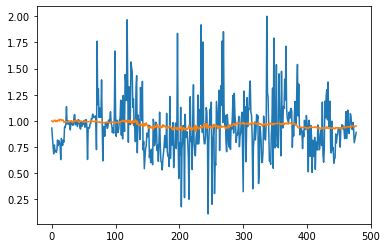

In [464]:
plt.plot(h_GARCH_arr)
plt.plot(h_ECDF_arr)

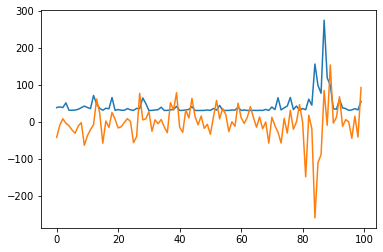

In [465]:
plt.plot(CV_rs)
plt.plot(rs)

In [466]:
rh_GARCH = train.iloc[block_size+1:, -1] - \
            np.array(h_GARCH_arr)[:-1]*train.iloc[block_size+1:,-2]

rh_ECDF = train.iloc[block_size+1:, -1] - \
            np.array(h_ECDF_arr)[:-1]*train.iloc[block_size+1:,-2]

rh_naive = train.iloc[block_size+1:, -1] - train.iloc[block_size+1:,-2]

rh_GARCH *= 100 
rh_ECDF *= 100 
rh_naive *= 100 

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

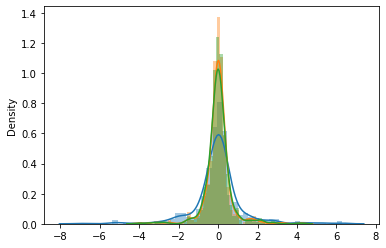

In [467]:
sns.distplot(rh_GARCH)
sns.distplot(rh_ECDF)
sns.distplot(rh_naive)

In [468]:
print(np.mean(rh_GARCH),
      np.mean(rh_ECDF), 
      np.mean(rh_naive))

print(np.std(rh_GARCH),
      np.std(rh_ECDF),
      np.std(rh_naive))

print(np.mean(rh_GARCH)/np.std(rh_GARCH),
      np.mean(rh_ECDF)/np.std(rh_ECDF), 
      np.mean(rh_naive)/np.std(rh_naive))

-0.002527049429398005 0.00829479771444703 -0.0015899758282242695
1.259378230974578 0.6614988525474336 0.6739585861209921
-0.0020065849696658893 0.012539398492535166 -0.002359159540314588


In [469]:
h_GARCH_arr = []
h_ECDF_arr = []

block_size = 100

for i in range(block_size, len(train)):
    print(i)
    rs = np.array(train.iloc[i-block_size:i, :].loc[:, 'log return bitcoin']*1000)
    rf = np.array(train.iloc[i-block_size:i, :].loc[:, 'log return future']*1000)
    
    am_rs = arch_model(rs, p=1, o=0, q=1, power=2, dist='studentst')
    res_rs = am_rs.fit(update_freq=0, disp="off")

    am_rf = arch_model(rf, p=1, o=0, q=1, power=2, dist='studentst')
    res_rf = am_rf.fit(update_freq=0, disp="off")

    u = []
    v = []

    CV_rs = res_rs.conditional_volatility
    nu_rs = res_rs.params.nu
    mu_rs = res_rs.params.mu

    CV_rf = res_rf.conditional_volatility
    nu_rf = res_rf.params.nu
    mu_rf = res_rf.params.mu

    for i in range(len(CV_rf)):
        if i == len(CV_rf)-1:
            break
        u.append(stats.t(df=nu_rs, scale=np.sqrt(CV_rs[i])).cdf(rs[i+1]-mu_rs))
        v.append(stats.t(df=nu_rf, scale=np.sqrt(CV_rf[i])).cdf(rf[i+1]-mu_rf))

        
    u = np.array(u)
    u[u==1] = 0.9999999999999999

    v = np.array(v)
    v[v==1] = 0.9999999999999999
    u_ecdf = ECDF(rs)(rs)
    v_ecdf = ECDF(rf)(rf)

#     C_GARCH = rot180Gumbel({'theta':1.1}, stats.uniform, stats.uniform)
#     C_GARCH = Gaussian({'rho':0.8}, stats.uniform, stats.uniform)
   #, q_arr=[0.05,0.1,0.9,0.95])
    C_GARCH = t_Copula({'rho':0.1, 'nu':4}, stats.uniform, stats.uniform, nu_lowerbound=2)
    C_GARCH.canonical_calibrate(np.array(u), np.array(v))

#     C_ECDF = Gaussian({'rho':0.8}, stats.uniform, stats.uniform)
#     C_ECDF = rot180Gumbel({'theta':1.1}, stats.uniform, stats.uniform)
    C_ECDF = t_Copula({'rho':0.1, 'nu':4}, stats.uniform, stats.uniform, nu_lowerbound=2)
    C_ECDF.canonical_calibrate(np.array(u_ecdf), np.array(v_ecdf) )

    # samples
    samples_GARCH = C_GARCH.sample(1000)
    samples_ECDF  = C_ECDF.sample(1000)

    samples_GARCH[:,0] = stats.t(df=nu_rs, scale=np.sqrt(CV_rs[-1])).ppf(samples_GARCH[:,0])\
                            +mu_rs
    samples_GARCH[:,1] = stats.t(df=nu_rf, scale=np.sqrt(CV_rf[-1])).ppf(samples_GARCH[:,1])\
                            +mu_rf

    samples_ECDF[:,0] = np.quantile(rs, samples_ECDF[:,0])
    samples_ECDF[:,1] = np.quantile(rf, samples_ECDF[:,1])

    h_arr = np.linspace(0,2,1000)

    var_GARCH = []
    var_ECDF = []

    for h in h_arr:
        var_GARCH.append(np.var(samples_GARCH[:,0] - h*samples_GARCH[:,1]))
        var_ECDF.append(np.var(samples_ECDF[:,0] - h*samples_ECDF[:,1]))

    h_GARCH = h_arr[np.argmin(var_GARCH)]
    h_ECDF = h_arr[np.argmin(var_ECDF)]
    
    h_GARCH_arr.append(h_GARCH)
    h_ECDF_arr.append(h_ECDF)
    print('%.4f %.4f' %(h_GARCH, h_ECDF))
    
print('Done!')

100


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -747.981908
         Iterations: 175
         Function evaluations: 344
Optimization terminated successfully.
         Current function value: -218.907936
         Iterations: 168
         Function evaluations: 317
0.9349 1.0130
101


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -736.744380
         Iterations: 171
         Function evaluations: 331
Optimization terminated successfully.
         Current function value: -229.704246
         Iterations: 130
         Function evaluations: 272
0.9309 0.9950
102


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -731.383221
         Iterations: 167
         Function evaluations: 324
Optimization terminated successfully.
         Current function value: -230.424688
         Iterations: 135
         Function evaluations: 281
0.9249 1.0010
103


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -749.433960
         Iterations: 182
         Function evaluations: 352
Optimization terminated successfully.
         Current function value: -230.938612
         Iterations: 133
         Function evaluations: 279
0.9309 0.9950
104


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -707.280240
         Iterations: 188
         Function evaluations: 343
Optimization terminated successfully.
         Current function value: -230.663876
         Iterations: 130
         Function evaluations: 275
0.9289 0.9930
105


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -680.127529
         Iterations: 163
         Function evaluations: 335
Optimization terminated successfully.
         Current function value: -231.705959
         Iterations: 161
         Function evaluations: 312
0.9469 1.0010
106
Optimization terminated successfully.
         Current function value: -638.116922
         Iterations: 135
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: -232.642179
         Iterations: 148
         Function evaluations: 308
0.9630 0.9930
107
Optimization terminated successfully.
         Current function value: -633.943693
         Iterations: 136
         Function evaluations: 282
Optimization terminated successfully.
         Current function value: -232.425940
         Iterations: 138
         Function evaluations: 288
0.9690 0.9950
108
Optimization terminated successfully.
         Current function value: -640.880768
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -706.213085
         Iterations: 182
         Function evaluations: 358
Optimization terminated successfully.
         Current function value: -233.400033
         Iterations: 135
         Function evaluations: 282
0.9209 0.9950
112


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -741.677625
         Iterations: 172
         Function evaluations: 328
Optimization terminated successfully.
         Current function value: -234.017325
         Iterations: 139
         Function evaluations: 288
0.9249 0.9990
113


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -695.406022
         Iterations: 180
         Function evaluations: 348
Optimization terminated successfully.
         Current function value: -236.702093
         Iterations: 125
         Function evaluations: 264
0.9329 1.0190
114
Optimization terminated successfully.
         Current function value: -649.145213
         Iterations: 153
         Function evaluations: 319
Optimization terminated successfully.
         Current function value: -232.866327
         Iterations: 135
         Function evaluations: 292
0.9389 1.0010
115


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -682.466701
         Iterations: 170
         Function evaluations: 336
Optimization terminated successfully.
         Current function value: -233.923982
         Iterations: 133
         Function evaluations: 280
0.9269 0.9950
116


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -716.566836
         Iterations: 188
         Function evaluations: 365
Optimization terminated successfully.
         Current function value: -232.916996
         Iterations: 126
         Function evaluations: 266
0.8869 1.0010
117


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -705.444366
         Iterations: 185
         Function evaluations: 351
Optimization terminated successfully.
         Current function value: -233.056600
         Iterations: 139
         Function evaluations: 291
0.9169 1.0070
118


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -731.055683
         Iterations: 164
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: -235.838921
         Iterations: 130
         Function evaluations: 271
0.9069 1.0010
119
Optimization terminated successfully.
         Current function value: -771.727523
         Iterations: 150
         Function evaluations: 316
Optimization terminated successfully.
         Current function value: -232.479633
         Iterations: 137
         Function evaluations: 280
0.9530 0.9870
120
Optimization terminated successfully.
         Current function value: -579.050246
         Iterations: 123
         Function evaluations: 268
Optimization terminated successfully.
         Current function value: -237.832103
         Iterations: 158
         Function evaluations: 335
0.9269 0.9950
121
Optimization terminated successfully.
         Current function value: -585.063488
     

Optimization terminated successfully.
         Current function value: -425.202758
         Iterations: 154
         Function evaluations: 304
Optimization terminated successfully.
         Current function value: -243.008269
         Iterations: 144
         Function evaluations: 284
0.9429 0.9890
147
Optimization terminated successfully.
         Current function value: -454.084878
         Iterations: 181
         Function evaluations: 344
Optimization terminated successfully.
         Current function value: -245.773643
         Iterations: 166
         Function evaluations: 312
0.9850 0.9890
148
Optimization terminated successfully.
         Current function value: -246.994333
         Iterations: 179
         Function evaluations: 341
0.9590 0.9890
149
Optimization terminated successfully.
         Current function value: -465.785570
         Iterations: 187
         Function evaluations: 356
Optimization terminated successfully.
         Current function value: -247.739746
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -324.273797
         Iterations: 193
         Function evaluations: 367
Optimization terminated successfully.
         Current function value: -258.342463
         Iterations: 192
         Function evaluations: 360
0.8428 0.9990
165
Optimization terminated successfully.
         Current function value: -408.988191
         Iterations: 122
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: -255.721046
         Iterations: 185
         Function evaluations: 359
0.9870 0.9970
166
Optimization terminated successfully.
         Current function value: -421.832463
         Iterations: 124
         Function evaluations: 261
Optimization terminated successfully.
         Current function value: -258.988400
         Iterations: 182
         Function evaluations: 344
0.9209 0.9950
167
Optimization terminated successfully.
         Current function value: -361.232220
     

Optimization terminated successfully.
         Current function value: -337.294313
         Iterations: 172
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: -252.578702
         Iterations: 163
         Function evaluations: 319
1.0651 0.9830
192
Optimization terminated successfully.
         Current function value: -331.031583
         Iterations: 190
         Function evaluations: 358
Optimization terminated successfully.
         Current function value: -254.515717
         Iterations: 187
         Function evaluations: 348
1.3253 0.9850
193
Optimization terminated successfully.
         Current function value: -341.732083
         Iterations: 187
         Function evaluations: 360
Optimization terminated successfully.
         Current function value: -256.681362
         Iterations: 180
         Function evaluations: 340
1.0731 0.9830
194
Optimization terminated successfully.
         Current function value: -335.812961
     

Optimization terminated successfully.
         Current function value: -279.350868
         Iterations: 160
         Function evaluations: 307
Optimization terminated successfully.
         Current function value: -193.342088
         Iterations: 171
         Function evaluations: 337
0.8188 0.9950
220
Optimization terminated successfully.
         Current function value: -242.104615
         Iterations: 124
         Function evaluations: 257
0.8569 1.0050
221
Optimization terminated successfully.
         Current function value: -226.063817
         Iterations: 121
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: -189.735140
         Iterations: 174
         Function evaluations: 335
0.8969 0.9970
222
Optimization terminated successfully.
         Current function value: -222.250933
         Iterations: 120
         Function evaluations: 253
0.9109 0.9850
223
Optimization terminated successfully.
         Current function value:

Optimization terminated successfully.
         Current function value: -164.707839
         Iterations: 186
         Function evaluations: 356
0.9329 0.9489
248
Optimization terminated successfully.
         Current function value: -213.687443
         Iterations: 115
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: -164.930088
         Iterations: 194
         Function evaluations: 369
0.9510 0.9530
249
Optimization terminated successfully.
         Current function value: -206.550480
         Iterations: 111
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: -164.081155
         Iterations: 177
         Function evaluations: 332
1.0090 0.9670
250
Optimization terminated successfully.
         Current function value: -209.306408
         Iterations: 114
         Function evaluations: 237
Optimization terminated successfully.
         Current function value: -162.460137
     

Optimization terminated successfully.
         Current function value: -236.185693
         Iterations: 198
         Function evaluations: 386
Optimization terminated successfully.
         Current function value: -141.052133
         Iterations: 193
         Function evaluations: 375
0.5566 0.9449
276
Optimization terminated successfully.
         Current function value: -235.886540
         Iterations: 178
         Function evaluations: 339
Optimization terminated successfully.
         Current function value: -141.119549
         Iterations: 194
         Function evaluations: 380
0.7367 0.9329
277
Optimization terminated successfully.
         Current function value: -228.109878
         Iterations: 155
         Function evaluations: 309
Optimization terminated successfully.
         Current function value: -140.142092
         Iterations: 172
         Function evaluations: 329
0.6847 0.9489
278
Optimization terminated successfully.
         Current function value: -222.063331
     

Optimization terminated successfully.
         Current function value: -126.114963
         Iterations: 194
         Function evaluations: 374
1.0591 0.9510
304
Optimization terminated successfully.
         Current function value: -191.357322
         Iterations: 175
         Function evaluations: 335
Optimization terminated successfully.
         Current function value: -127.179114
         Iterations: 183
         Function evaluations: 358
0.7708 0.9149
305
Optimization terminated successfully.
         Current function value: -185.321701
         Iterations: 172
         Function evaluations: 334
Optimization terminated successfully.
         Current function value: -126.271050
         Iterations: 149
         Function evaluations: 289
0.8929 0.9229
306
Optimization terminated successfully.
         Current function value: -184.204564
         Iterations: 168
         Function evaluations: 327
Optimization terminated successfully.
         Current function value: -125.585904
     

Optimization terminated successfully.
         Current function value: -234.655246
         Iterations: 157
         Function evaluations: 302
Optimization terminated successfully.
         Current function value: -157.154823
         Iterations: 178
         Function evaluations: 339
0.8789 0.9429
333
Optimization terminated successfully.
         Current function value: -226.958997
         Iterations: 174
         Function evaluations: 330
Optimization terminated successfully.
         Current function value: -154.706154
         Iterations: 164
         Function evaluations: 309
0.6146 0.9309
334
Optimization terminated successfully.
         Current function value: -231.994737
         Iterations: 144
         Function evaluations: 280
Optimization terminated successfully.
         Current function value: -152.218104
         Iterations: 135
         Function evaluations: 268
0.7387 0.9209
335
Optimization terminated successfully.
         Current function value: -225.714231
     

Optimization terminated successfully.
         Current function value: -146.233158
         Iterations: 184
         Function evaluations: 351
0.3423 0.9510
361
Optimization terminated successfully.
         Current function value: -190.564342
         Iterations: 175
         Function evaluations: 343
1.0891 0.9129
362
Optimization terminated successfully.
         Current function value: -195.701149
         Iterations: 189
         Function evaluations: 365
Optimization terminated successfully.
         Current function value: -150.829341
         Iterations: 173
         Function evaluations: 337
0.9510 0.9489
363
Optimization terminated successfully.
         Current function value: -151.384245
         Iterations: 181
         Function evaluations: 349
1.3253 0.9389
364
Optimization terminated successfully.
         Current function value: -195.737645
         Iterations: 178
         Function evaluations: 329
Optimization terminated successfully.
         Current function value:

Optimization terminated successfully.
         Current function value: -286.799879
         Iterations: 182
         Function evaluations: 343
Optimization terminated successfully.
         Current function value: -205.581156
         Iterations: 186
         Function evaluations: 354
0.8028 0.9530
391
Optimization terminated successfully.
         Current function value: -209.067319
         Iterations: 151
         Function evaluations: 297
0.8569 0.9790
392
Optimization terminated successfully.
         Current function value: -256.989901
         Iterations: 168
         Function evaluations: 322
Optimization terminated successfully.
         Current function value: -212.351281
         Iterations: 189
         Function evaluations: 355
1.5616 0.9710
393
Optimization terminated successfully.
         Current function value: -209.724877
         Iterations: 122
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: -215.863224
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -135.532538
         Iterations: 165
         Function evaluations: 323
Optimization terminated successfully.
         Current function value: -210.839422
         Iterations: 195
         Function evaluations: 373
1.9820 0.9890
407
Optimization terminated successfully.
         Current function value: -215.451920
         Iterations: 122
         Function evaluations: 256
Optimization terminated successfully.
         Current function value: -211.580714
         Iterations: 177
         Function evaluations: 335
0.5445 0.9710
408
Optimization terminated successfully.
         Current function value: -149.540737
         Iterations: 146
         Function evaluations: 295
Optimization terminated successfully.
         Current function value: -211.443766
         Iterations: 174
         Function evaluations: 329
1.7918 0.9670
409
Optimization terminated successfully.
         Current function value: -219.621472
     

Optimization terminated successfully.
         Current function value: -262.112346
         Iterations: 177
         Function evaluations: 345
Optimization terminated successfully.
         Current function value: -217.072135
         Iterations: 139
         Function evaluations: 274
1.2492 0.9590
435
Optimization terminated successfully.
         Current function value: -265.997835
         Iterations: 177
         Function evaluations: 340
Optimization terminated successfully.
         Current function value: -220.551921
         Iterations: 185
         Function evaluations: 349
0.7968 0.9790
436
Optimization terminated successfully.
         Current function value: -268.751604
         Iterations: 151
         Function evaluations: 293
Optimization terminated successfully.
         Current function value: -220.615148
         Iterations: 192
         Function evaluations: 370
0.9850 0.9730
437
Optimization terminated successfully.
         Current function value: -269.305783
     

Optimization terminated successfully.
         Current function value: -291.562495
         Iterations: 196
         Function evaluations: 380
Optimization terminated successfully.
         Current function value: -251.638944
         Iterations: 208
         Function evaluations: 390
1.1171 0.9750
463
Optimization terminated successfully.
         Current function value: -292.945103
         Iterations: 175
         Function evaluations: 334
Optimization terminated successfully.
         Current function value: -253.304300
         Iterations: 179
         Function evaluations: 333
0.8168 0.9790
464
Optimization terminated successfully.
         Current function value: -298.473394
         Iterations: 177
         Function evaluations: 342
Optimization terminated successfully.
         Current function value: -255.435966
         Iterations: 184
         Function evaluations: 346
0.8829 0.9690
465
Optimization terminated successfully.
         Current function value: -297.284851
     

Optimization terminated successfully.
         Current function value: -249.592318
         Iterations: 185
         Function evaluations: 353
1.0531 0.9309
490
Optimization terminated successfully.
         Current function value: -266.091497
         Iterations: 190
         Function evaluations: 363
1.1491 0.9349
491
Optimization terminated successfully.
         Current function value: -264.740712
         Iterations: 164
         Function evaluations: 319
Optimization terminated successfully.
         Current function value: -248.094937
         Iterations: 145
         Function evaluations: 290
1.6076 0.9389
492
Optimization terminated successfully.
         Current function value: -281.828161
         Iterations: 177
         Function evaluations: 334
Optimization terminated successfully.
         Current function value: -248.958091
         Iterations: 149
         Function evaluations: 289
0.9329 0.9329
493
Optimization terminated successfully.
         Current function value:

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -155.556418
         Iterations: 193
         Function evaluations: 381
Optimization terminated successfully.
         Current function value: -250.411249
         Iterations: 197
         Function evaluations: 373
1.3994 0.9329
511
Optimization terminated successfully.
         Current function value: -269.099214
         Iterations: 186
         Function evaluations: 354
Optimization terminated successfully.
         Current function value: -246.147040
         Iterations: 190
         Function evaluations: 365
0.8869 0.9329
512
Optimization terminated successfully.
         Current function value: -269.633048
         Iterations: 182
         Function evaluations: 343
Optimization terminated successfully.
         Current function value: -243.779911
         Iterations: 145
         Function evaluations: 288
0.9369 0.9389
513
Optimization terminated successfully.
         Current function value: -273.296714
     

Optimization terminated successfully.
         Current function value: -245.848175
         Iterations: 179
         Function evaluations: 345
Optimization terminated successfully.
         Current function value: -230.831458
         Iterations: 177
         Function evaluations: 345
0.7808 0.9369
539
Optimization terminated successfully.
         Current function value: -246.019821
         Iterations: 196
         Function evaluations: 371
Optimization terminated successfully.
         Current function value: -229.580730
         Iterations: 207
         Function evaluations: 395
0.7247 0.9349
540
Optimization terminated successfully.
         Current function value: -246.241590
         Iterations: 160
         Function evaluations: 310
Optimization terminated successfully.
         Current function value: -230.182686
         Iterations: 156
         Function evaluations: 304
0.8869 0.9309
541
Optimization terminated successfully.
         Current function value: -246.803834
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -163.458076
         Iterations: 190
         Function evaluations: 371
Optimization terminated successfully.
         Current function value: -228.501658
         Iterations: 185
         Function evaluations: 350
0.5185 0.9369
545


../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -153.664442
         Iterations: 192
         Function evaluations: 375
0.4705 0.9389
546
Optimization terminated successfully.
         Current function value: -276.003651
         Iterations: 127
         Function evaluations: 263
Optimization terminated successfully.
         Current function value: -230.540152
         Iterations: 177
         Function evaluations: 337
1.0470 0.9329
547
Optimization terminated successfully.
         Current function value: -256.534725
         Iterations: 177
         Function evaluations: 340
Optimization terminated successfully.
         Current function value: -228.127158
         Iterations: 175
         Function evaluations: 333
0.9209 0.9349
548
Optimization terminated successfully.
         Current function value: -252.097693
         Iterations: 147
         Function evaluations: 302
Optimization terminated successfully.
         Current function value: -233.212286
     

../../src/toolbox.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return (part1 / part2) * part3
../../src/toolbox.py:43: RuntimeWarning: overflow encountered in double_scalars
  part2 = scipy.special.gamma(self.nu / 2) * np.sqrt(((np.pi * self.nu) ** self.d) * la.det(self.Sigma))
../../src/copulae1.py:261: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(part1 / part2))


Optimization terminated successfully.
         Current function value: -182.495833
         Iterations: 177
         Function evaluations: 347
Optimization terminated successfully.
         Current function value: -218.767766
         Iterations: 164
         Function evaluations: 308
1.2953 0.9389
557
Optimization terminated successfully.
         Current function value: -304.788786
         Iterations: 130
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: -221.042302
         Iterations: 177
         Function evaluations: 337
0.9429 0.9349
558
Optimization terminated successfully.
         Current function value: -244.232183
         Iterations: 152
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: -219.091005
         Iterations: 167
         Function evaluations: 326
1.0771 0.9329
559
Optimization terminated successfully.
         Current function value: -285.303058
     

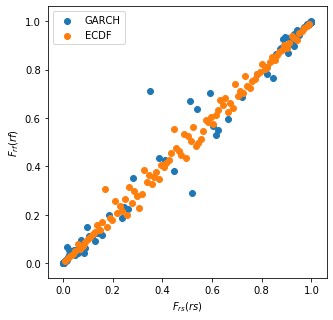

In [483]:
plt.figure(figsize=(5,5))
plt.scatter(u, v, label='GARCH')
plt.scatter(u_ecdf, v_ecdf, label='ECDF')
plt.xlabel(r'$F_{rs}(rs)$')
plt.ylabel(r'$F_{rf}(rf)$')
plt.legend()

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


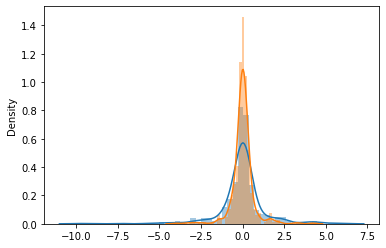

In [484]:
rh_GARCH = train.iloc[block_size+1:, -1] - \
            np.array(h_GARCH_arr)[:-1]*train.iloc[block_size+1:,-2]

rh_ECDF = train.iloc[block_size+1:, -1] - \
            np.array(h_ECDF_arr)[:-1]*train.iloc[block_size+1:,-2]

rh_naive = train.iloc[block_size+1:, -1] - train.iloc[block_size+1:,-2]

rh_GARCH *= 100 
rh_ECDF *= 100 
rh_naive *= 100 

sns.distplot(rh_GARCH)
sns.distplot(rh_ECDF)
# sns.distplot(rh_naive)

In [471]:
print(np.mean(rh_GARCH),
      np.mean(rh_ECDF), 
      np.mean(rh_naive))

print(np.std(rh_GARCH),
      np.std(rh_ECDF),
      np.std(rh_naive))

print(np.mean(rh_GARCH)/np.std(rh_GARCH),
      np.mean(rh_ECDF)/np.std(rh_ECDF), 
      np.mean(rh_naive)/np.std(rh_naive))

-0.014139812682473827 0.007154624545114433 -0.0015899758282242695
1.3820697205010262 0.6608729334259448 0.6739585861209921
-0.010230896801174314 0.010826021438077486 -0.002359159540314588


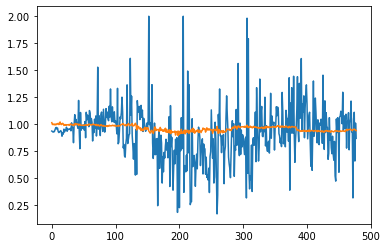

In [472]:
plt.plot(h_GARCH_arr)
plt.plot(h_ECDF_arr)